# 数据预处理

### 数据对齐


In [8]:
import pandas as pd
import numpy as np
import re
import glob
import os
import time
from copy import deepcopy
from tqdm import tqdm
from datetime import datetime, timedelta
from angle_calculator import angle_cal_frame
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [9]:
# 判断时间 n_time 是否在范围时间 [time1, time2] 内
def time_in_period(time1, time2, n_time):
    return (n_time > time1 and n_time < time2)

def get_start_time(optical_data):
    start_time = datetime.strptime(optical_data.iloc[0,0], '%Y-%m-%d %I.%M.%S %p')
    return start_time

### sensor_data 写入时间戳

time shift:
- 第一次采集：minutes=23, seconds=45
- 第二次采集：minutes=25, seconds=14

In [10]:
def sensor_data_processing(sensor_data):
    timestamp = dict()
    key = list()
    sensor_data_list = sensor_data.values.tolist()
    num_sensor_data = len(sensor_data_list)
    
    # 提取中括号中的时间
    re_midbkt = re.compile('\[(.*?)\]', re.S)
    for i, data in enumerate(sensor_data_list):
        if sensor_data_list[i][0].split(' ')[0][0] == '[':
            t = sensor_data_list[i][0].split(' ')[0]
            timestamp[i] = re.findall(re_midbkt, t)[0]
            timestamp[i] = datetime.strptime(timestamp[i], '%H:%M:%S.%f')
            # 时间对齐
            timeshift = timedelta(minutes=25, seconds=14)
            timestamp[i] = timestamp[i] + timeshift
            timestamp[i] = timestamp[i].replace(year=start_time.year, month=start_time.month, day=start_time.day)
            key.append(i)
    if key[-1] != len(sensor_data_list)-1:
        key.append(len(sensor_data_list)-1)


    # 生成每一行的时间
    # 针对末尾数据，默认 time_addition 为本次数据采集的平均间隔
    mean_time_addition = (timestamp[key[-2]] - timestamp[0]) / (key[-2] - key[0])
    for i in range(len(key)-1):
        if (i==len(key)-2):
            time_addition = mean_time_addition
            for idx, j in enumerate(range(key[-2]+1, key[-1]+1)):
                if j in key:
                    continue
                timestamp[j] = timestamp[key[-2]] + time_addition * (idx+1)
            break

        else:
            time_interval = timestamp[key[i+1]] - timestamp[key[i]]
            index_interval = key[i+1] - key[i]
            time_addition = time_interval / index_interval
            for idx, j in enumerate(range(key[i]+1, key[i+1])):
                if j in key:
                    continue
                timestamp[j] = timestamp[key[i]] + time_addition * (idx+1)

    timestamp = dict(sorted(timestamp.items()))
    pair = [[timestamp[i-1], timestamp[i]] for i in range(1, len(timestamp))]
    
    # 提取传感器数据到列表
    for i in range(len(sensor_data_list)):
        s = sensor_data_list[i][0]
        a = re.sub(u"\\(.*?\\)|\\{.*?}|\\[.*?]", "", s)
        # 去除字符串两端空格
        sensor_str = a.split(',')[:-1]
        sensor_str = [float(i.strip()) for i in sensor_str]
        sensor_data_list[i] = sensor_str
        
    return sensor_data_list, pair

### optical_data 写入时间戳

In [11]:
def optical_data_processing(optical_data, sensor_data_list, pair, is_save=False):
    num_sample = optical_data.shape[0]
    start_time = get_start_time(optical_data)
    optical_data.drop([0], inplace=True)
    optical_data.dropna(inplace=True)
    optical_data.reset_index(drop=True, inplace=True)
    print(f'清洗数据：({optical_data.shape[0]}/{num_sample})')

    for i in tqdm(range(1, optical_data.shape[0])):
        row_time = optical_data.loc[i, 'Time']
        row_time = timedelta(seconds=row_time) + start_time
        # 写入 optical_data 时间戳
        optical_data.loc[i, 'Time'] = datetime.strftime(row_time, '%Y-%m-%d %H:%M:%S.%f')
        # 写入角度数据
        angle_result = angle_cal_frame(optical_data, i-1)
        optical_data.loc[i, 'AA_SN_X'] = angle_result['AA_SN_X'].to_numpy()[0]
        optical_data.loc[i, 'AA_SN_Y'] = angle_result['AA_SN_Y'].to_numpy()[0]
        optical_data.loc[i, 'AA_SN_Z'] = angle_result['AA_SN_Z'].to_numpy()[0]
        optical_data.loc[i, 'GH_AA_X'] = angle_result['GH_AA_X'].to_numpy()[0]
        optical_data.loc[i, 'GH_AA_Y'] = angle_result['GH_AA_Y'].to_numpy()[0]
        optical_data.loc[i, 'GH_AA_Z'] = angle_result['GH_AA_Z'].to_numpy()[0]
        optical_data.loc[i, 'GH_SN_X'] = angle_result['GH_SN_X'].to_numpy()[0]
        optical_data.loc[i, 'GH_SN_Y'] = angle_result['GH_SN_Y'].to_numpy()[0]
        optical_data.loc[i, 'GH_SN_Z'] = angle_result['GH_SN_Z'].to_numpy()[0]
        
        for idx, p in enumerate(pair):
            is_in_period = time_in_period(p[0], p[1], row_time)
            if is_in_period:
                # 写入 sensor_data 时间戳
                optical_data.loc[i, 'sensor_0'] = sensor_data_list[idx][0]
                optical_data.loc[i, 'sensor_1'] = sensor_data_list[idx][1]
                optical_data.loc[i, 'sensor_2'] = sensor_data_list[idx][2]
                optical_data.loc[i, 'sensor_3'] = sensor_data_list[idx][3]
                optical_data.loc[i, 'sensor_4'] = sensor_data_list[idx][4]
                break

    if is_save:
        save_path = optical_csv_path.replace('learning', 'processing')
        optical_data.to_csv(save_path)
        print(f'处理结束，保存路径:{save_path}')
        
    return optical_data

## 合并 optical_data 和 sensor_data

In [ ]:
sensor_csv_paths = glob.glob('./data/learning0627/*_s*')
for sensor_csv_path in sensor_csv_paths:
    optical_csv_path = re.sub('[_][s]','', sensor_csv_path)
    print(f'正在处理 {sensor_csv_path} & {optical_csv_path}')
    print('='*20)
    sensor_data = pd.read_csv(sensor_csv_path, header=None)
    optical_data = pd.read_csv(optical_csv_path)
    start_time = get_start_time(optical_data)
    sensor_data_list, pair = sensor_data_processing(sensor_data)
    optical_data = optical_data_processing(optical_data, sensor_data_list, pair, True)

## 合并多个文件

In [21]:
def read_csv(dataset_path):
    data_frame = pd.read_csv(dataset_path)
    num_sample = data_frame.shape[0]
    data_frame.dropna(inplace=True)
    data_frame.reset_index(drop=True, inplace=True)
    data_frame = data_frame.iloc[:,-14:]
    print(f'清洗数据：({data_frame.shape[0]}/{num_sample})')
    return data_frame

def parse_sensor_angle(data_frame, cut=(None,None)):
    sensor = np.array([data_frame.iloc[:, -5:]]).astype('float').squeeze()[cut[0]:cut[1]]
    angle = np.array([data_frame.iloc[:, -14:-8]]).astype('float').squeeze()[cut[0]:cut[1]]
    return sensor, angle

def concat_multi_data(folder_path, cut_list, do_plot=True):
    global sensor_total, angle_total
    processing_csv_paths = glob.glob(folder_path)
    for idx, csv_file in enumerate(processing_csv_paths):
        data_frame = read_csv(csv_file)
        print(csv_file)
        sensor, angle = parse_sensor_angle(data_frame, cut=cut_list[idx])
        if idx == 0:
            sensor_total = sensor
            angle_total = angle

        sensor_total = np.concatenate((sensor_total, sensor), axis=0)
        angle_total = np.concatenate((angle_total, angle), axis=0)

        if do_plot:
            figure(figsize=(16, 9), dpi=100)
            for i in range(5):
                plt.title(csv_file)
                plt.plot(sensor[:,i])  

In [32]:
sensor_total = None
angle_total = None
folder_path = './data/processing/*'
folder_path_0627 = './data/processing0627/*'
cut_list = [(None,None), (None,-300), (None,None), 
            (100,None), (None,None), (100,None), 
            (100,None), (100,None)]
cut_list_0627 = [(None,None), (100,None), (None,None), 
                 (None,None), (None,None), (None,None), (None,None)]

清洗数据：(3659/3711)
./data/processing/InitialData.csv
清洗数据：(3523/3707)
./data/processing/Backward.csv
清洗数据：(2015/2019)
./data/processing/Depression.csv
清洗数据：(3873/4387)
./data/processing/Qianqu.csv
清洗数据：(3594/3740)
./data/processing/HoushenBackward.csv
清洗数据：(3683/3763)
./data/processing/QianquForward.csv
清洗数据：(2156/2254)
./data/processing/WaizhanElevation.csv
清洗数据：(3528/3610)
./data/processing/Elevation.csv
清洗数据：(3502/3712)
./data/processing0627/WaizhanElevationForward.csv
清洗数据：(3573/3686)
./data/processing0627/Waizhan.csv
清洗数据：(3515/3729)
./data/processing0627/Depression.csv
清洗数据：(3233/3593)
./data/processing0627/Qianqu.csv
清洗数据：(3468/3699)
./data/processing0627/Forward.csv
清洗数据：(3417/3670)
./data/processing0627/WaizhanElevation.csv
清洗数据：(3428/3693)
./data/processing0627/Houshen.csv


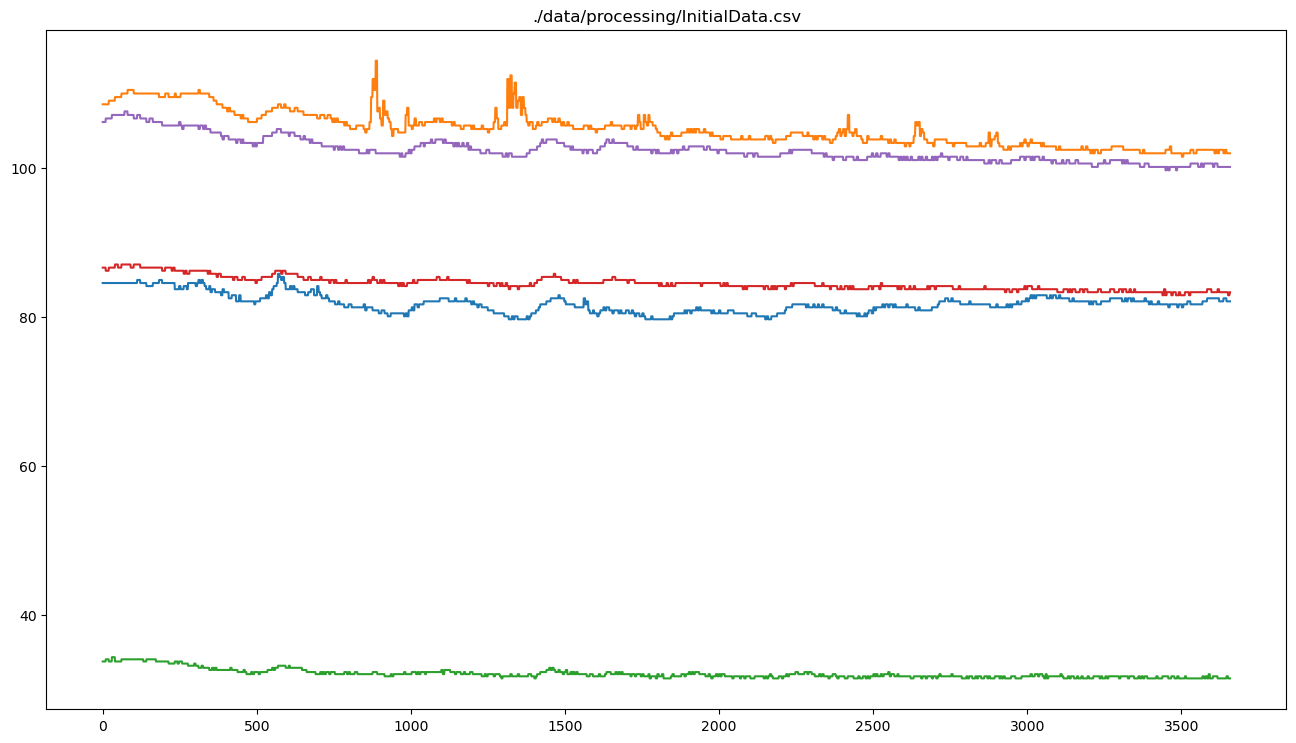

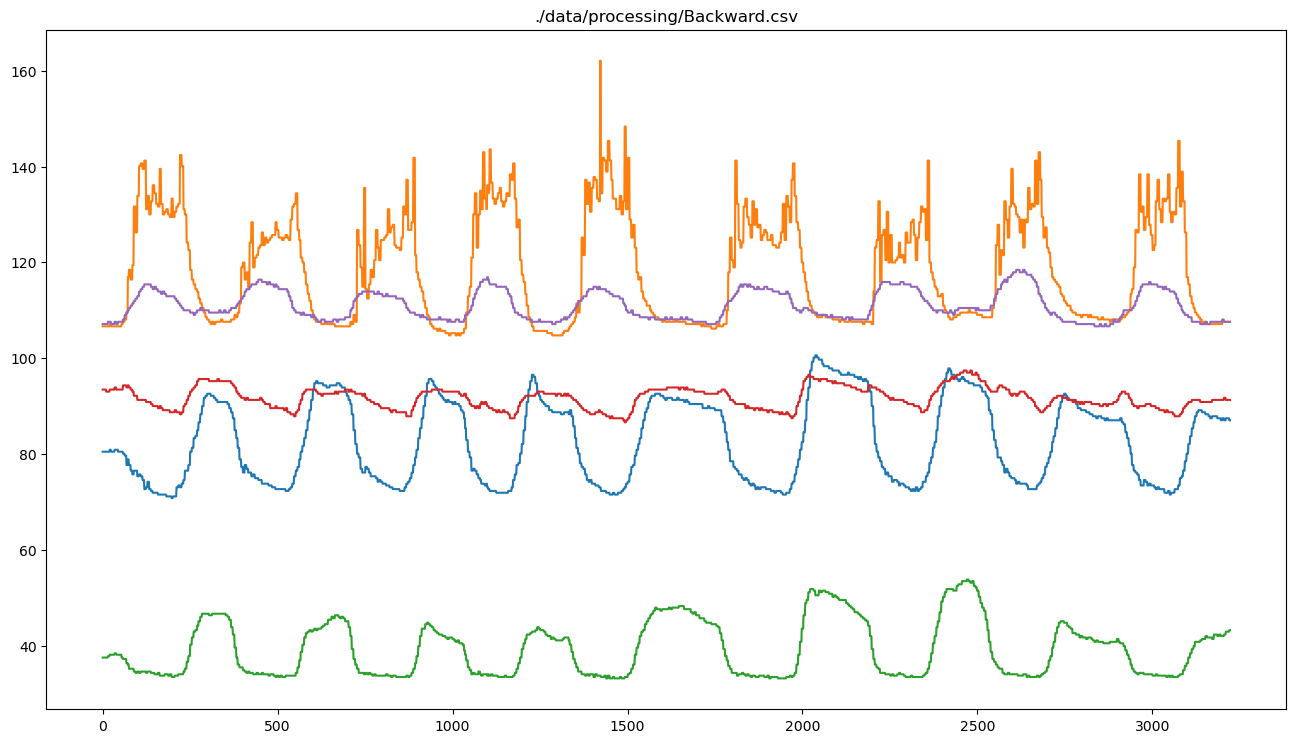

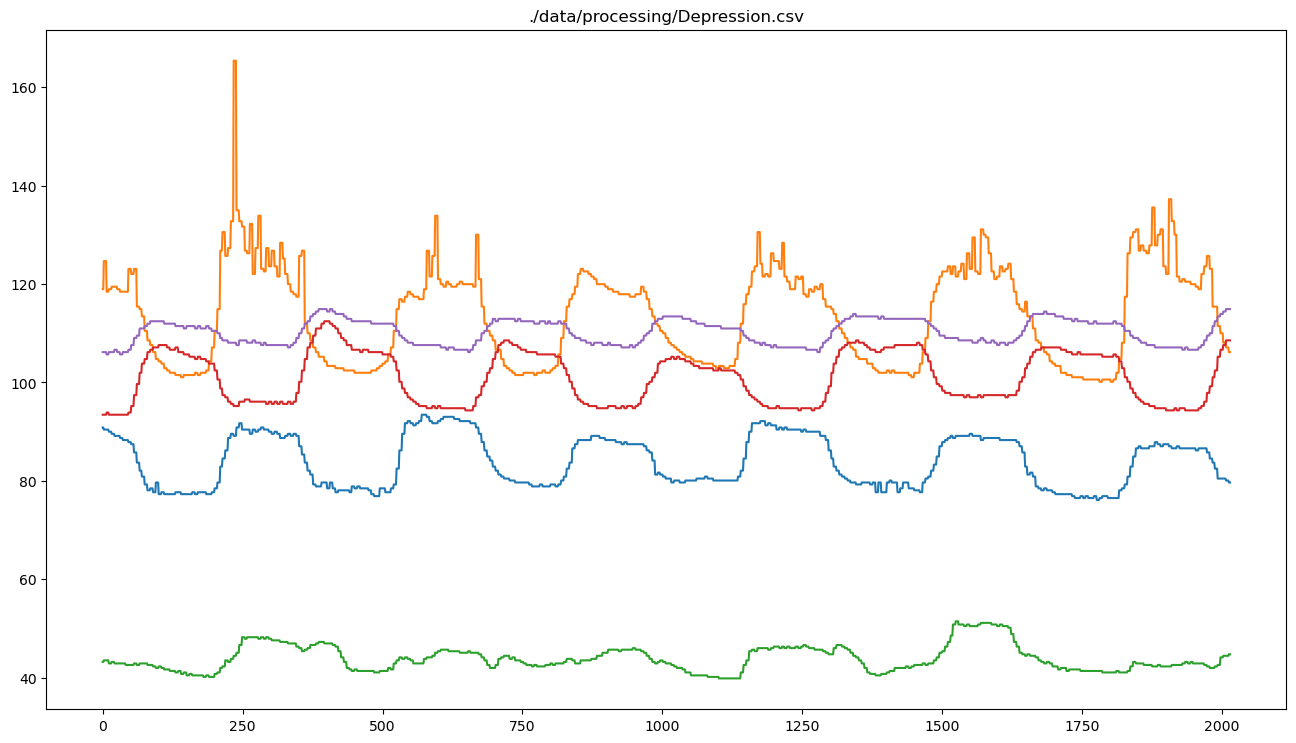

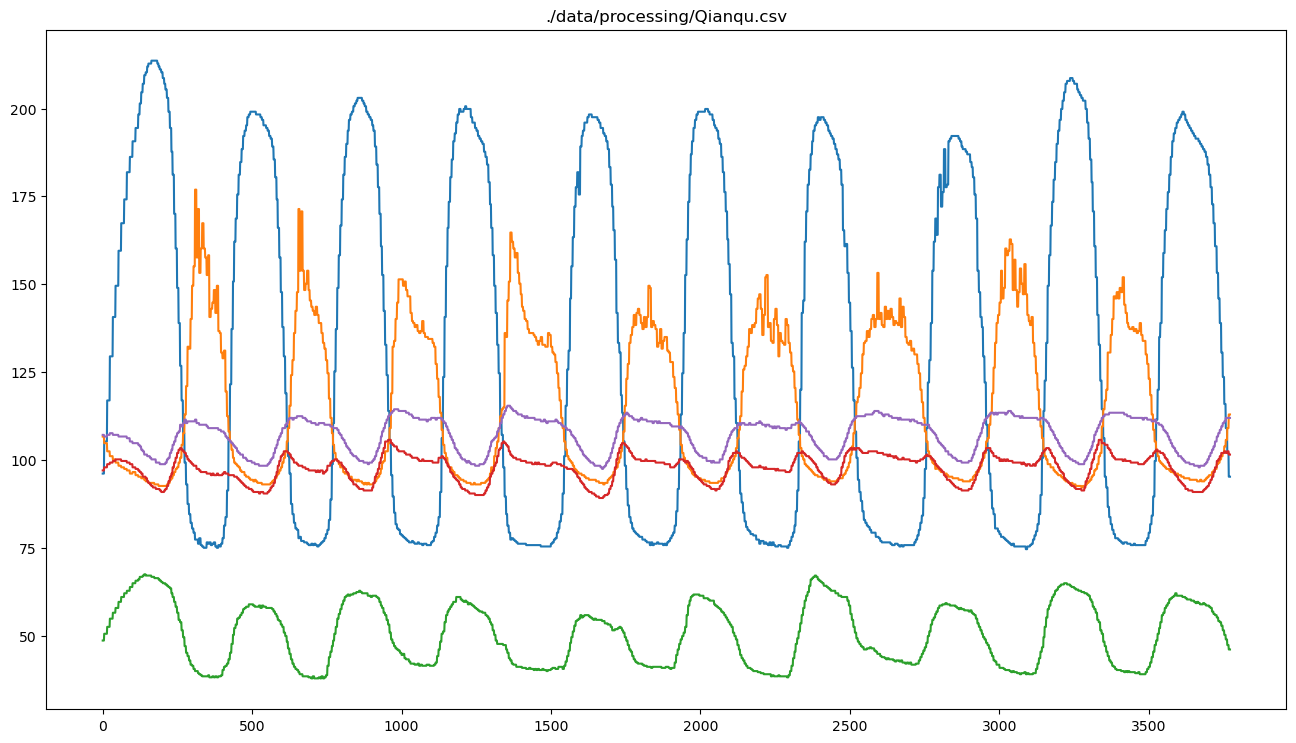

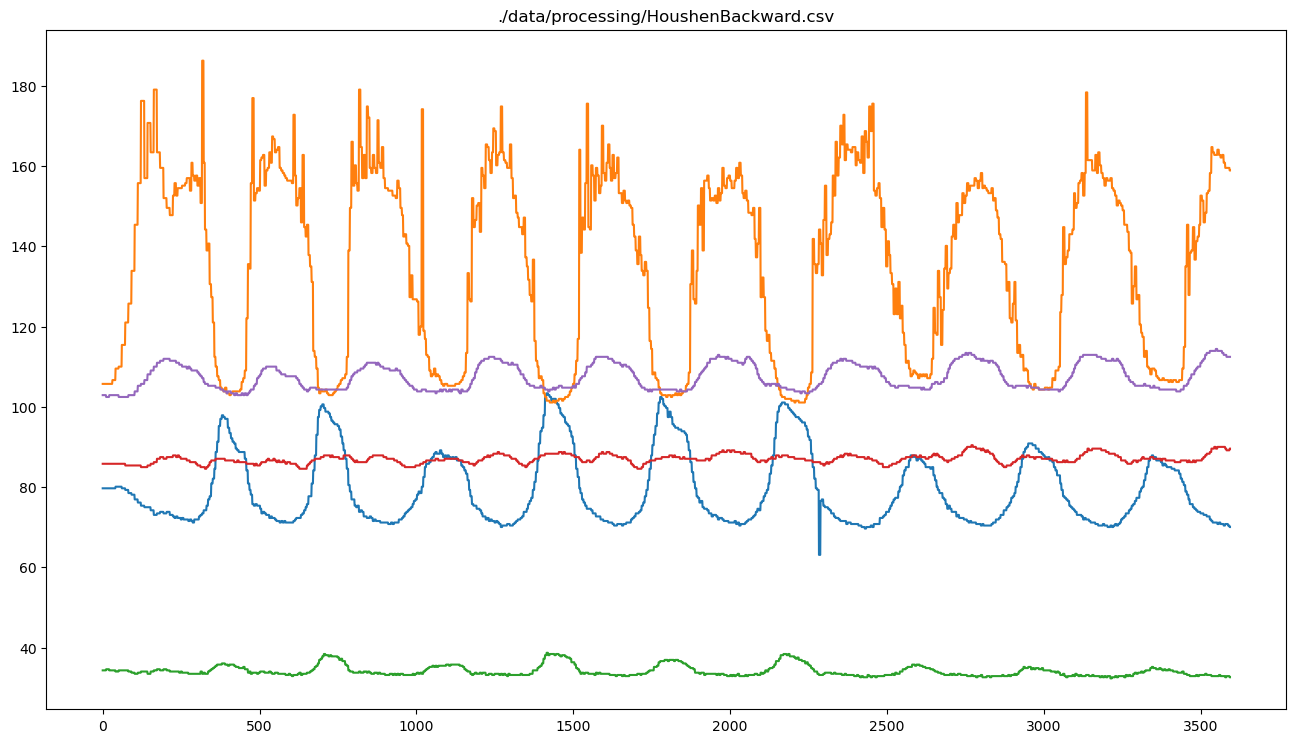

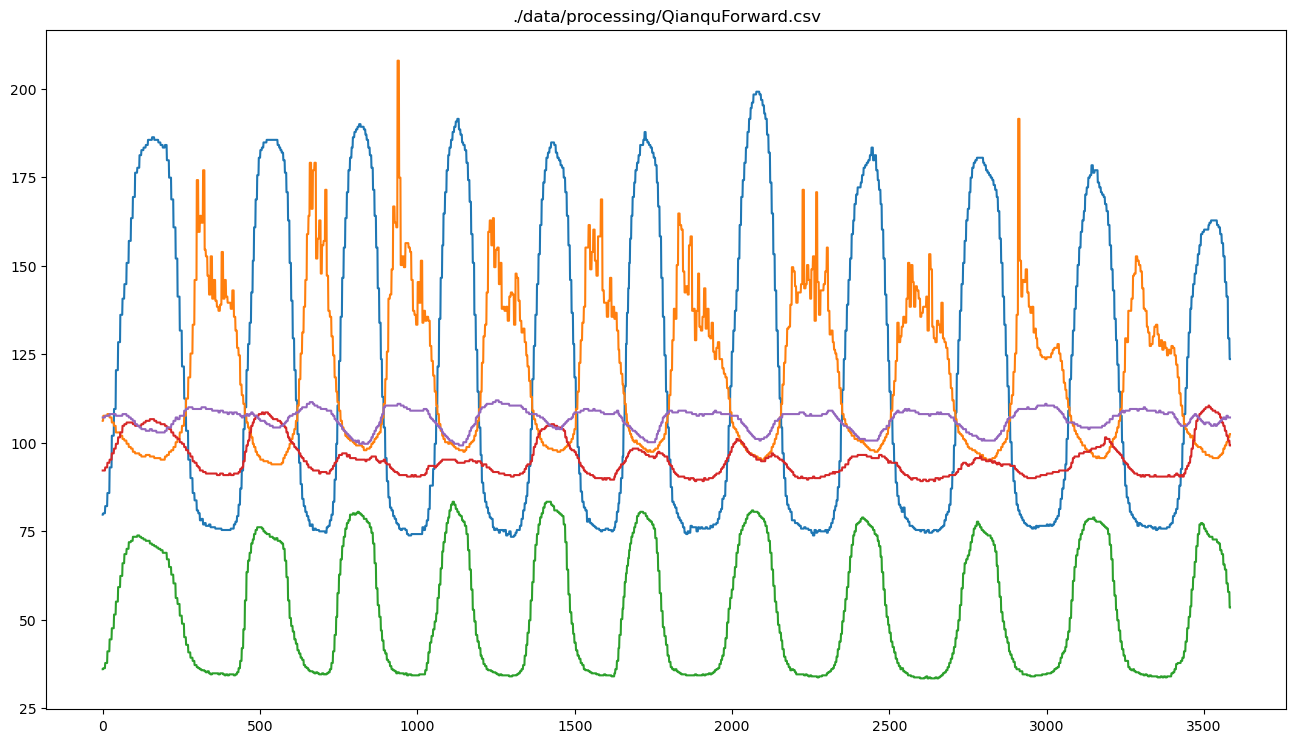

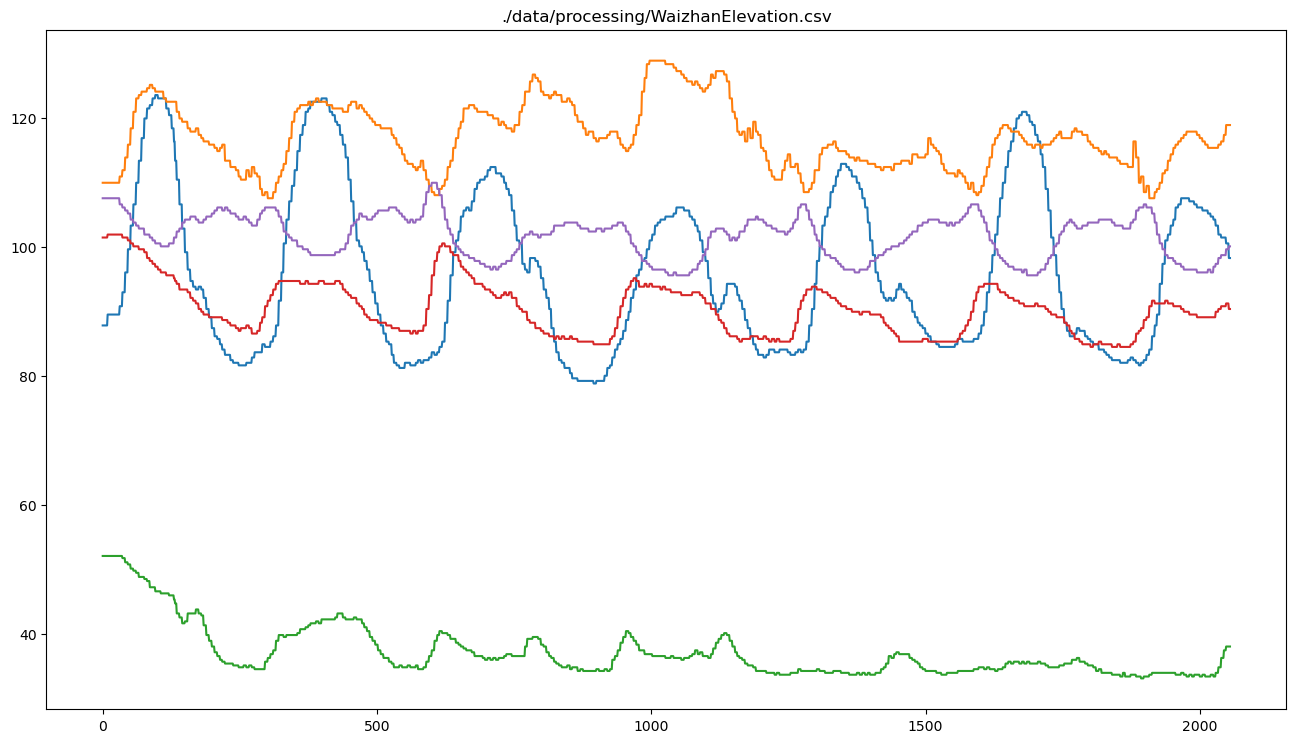

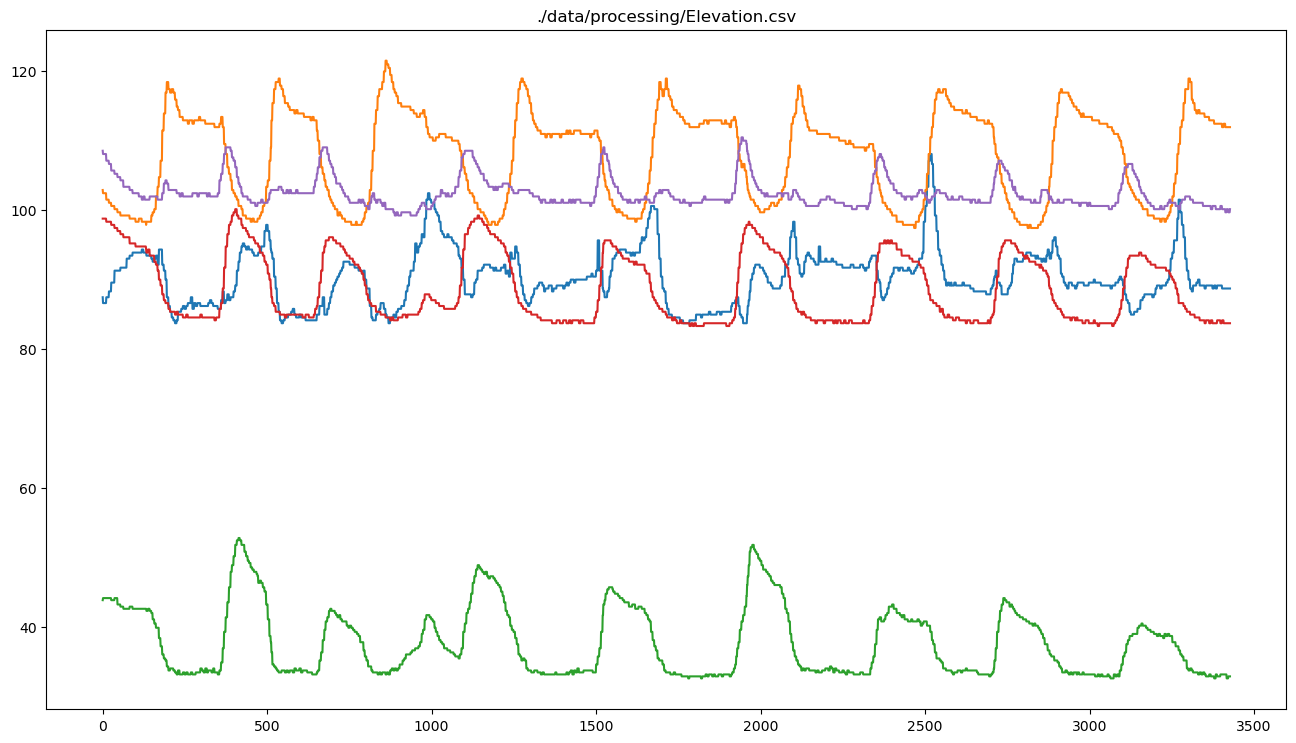

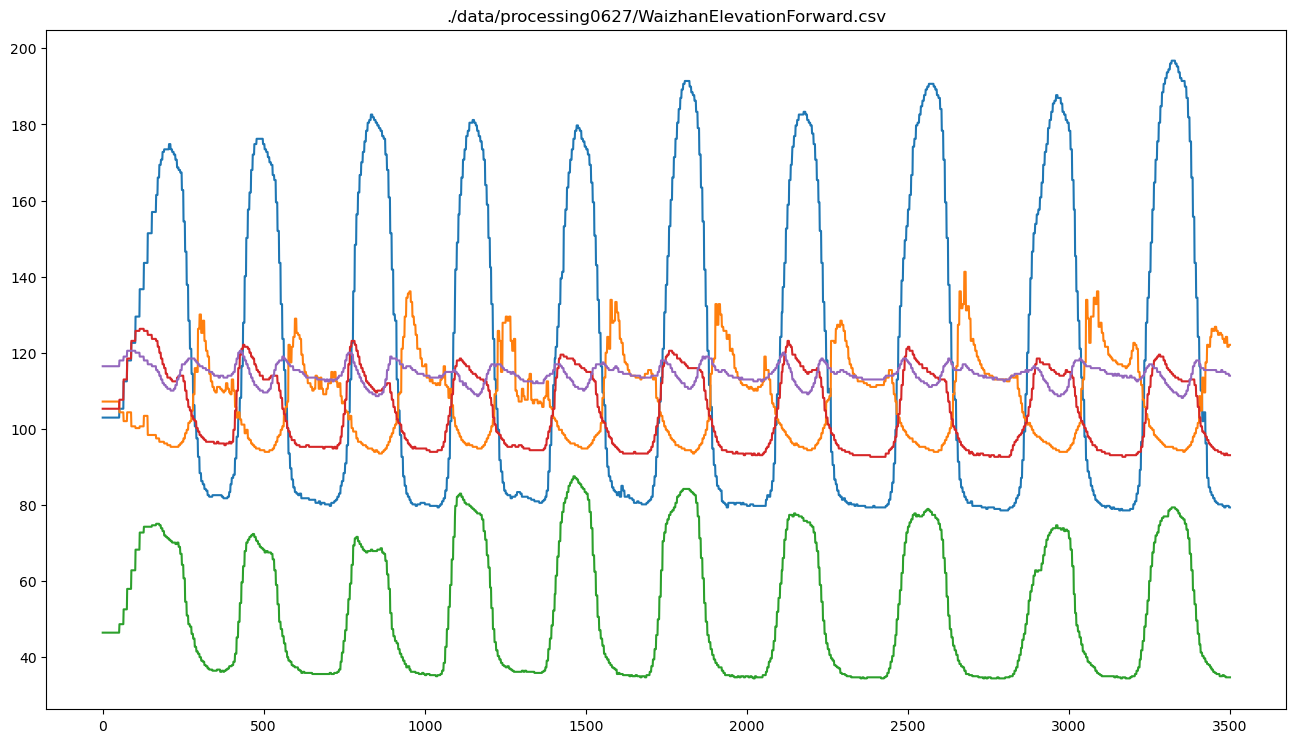

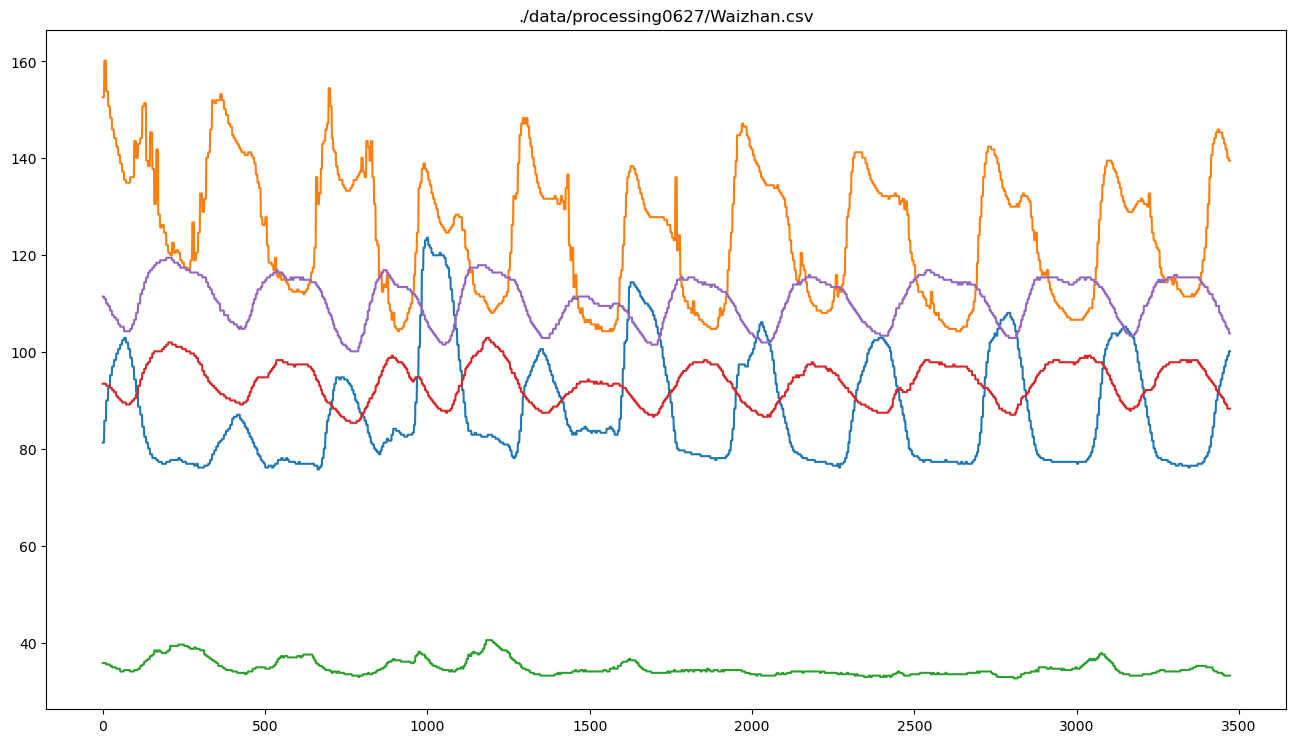

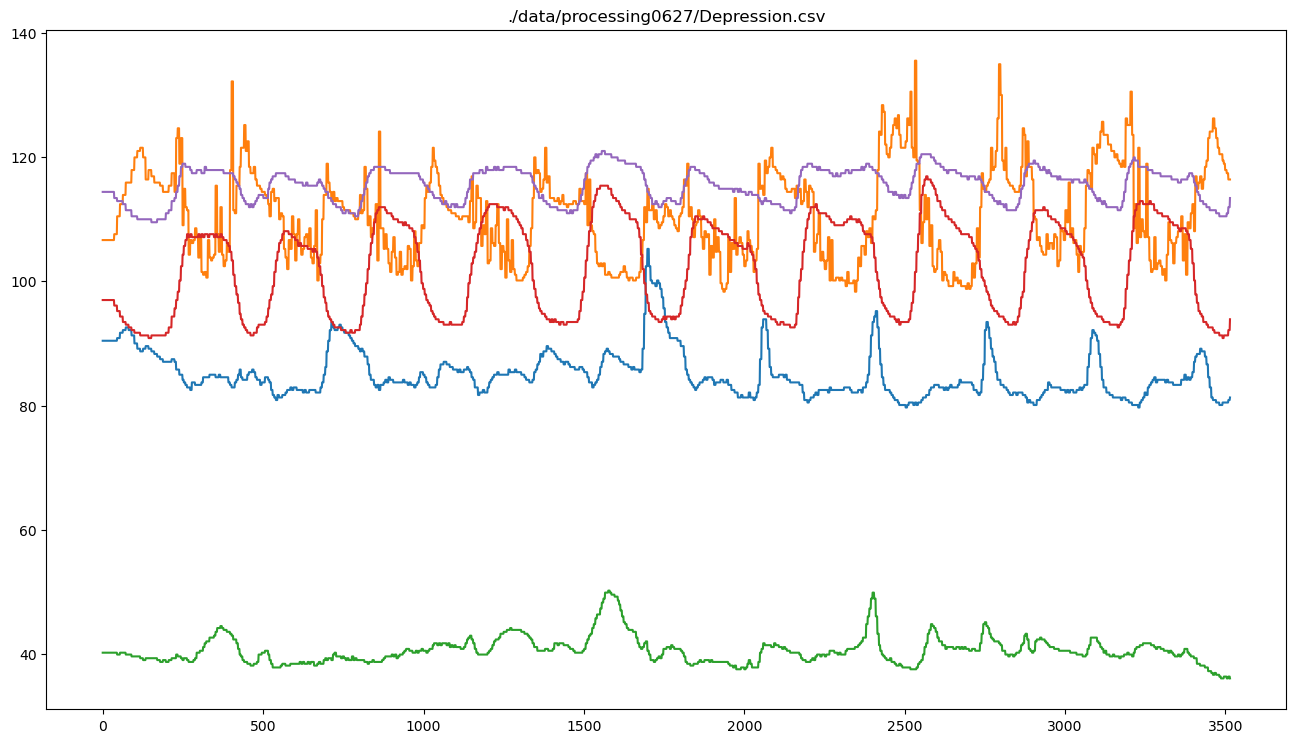

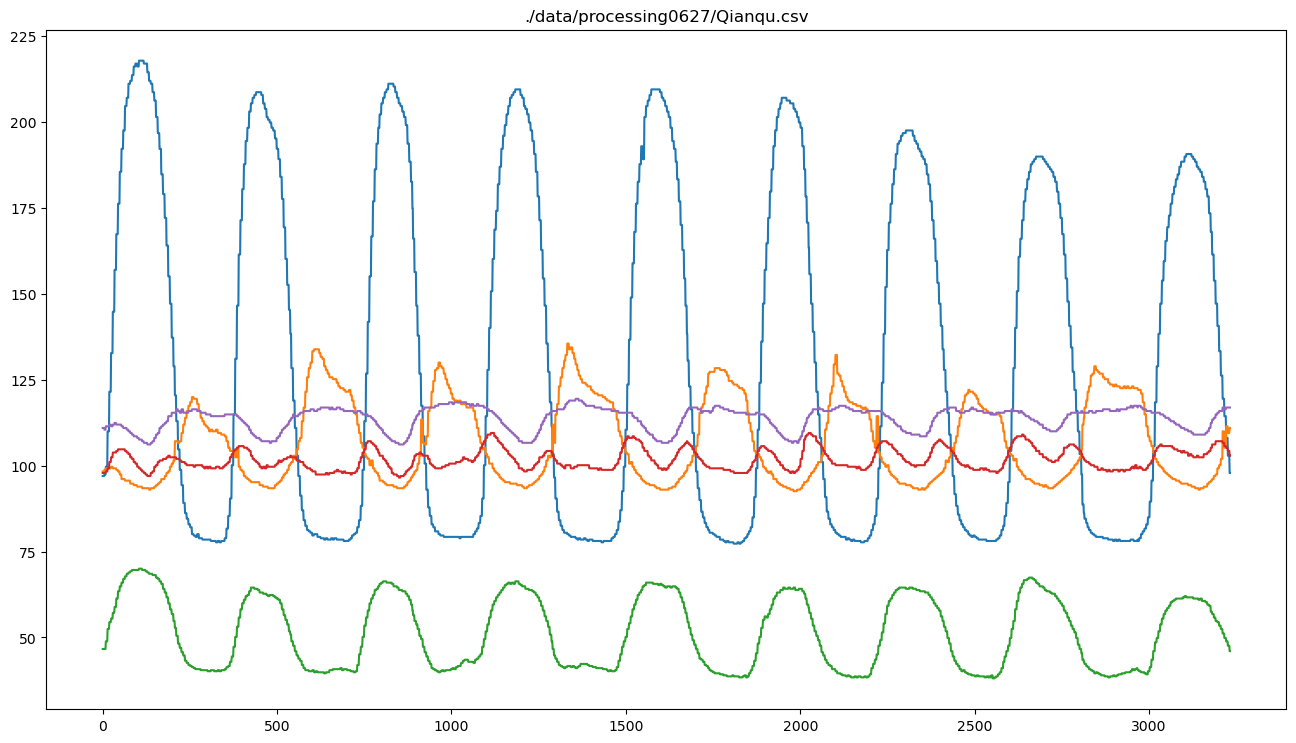

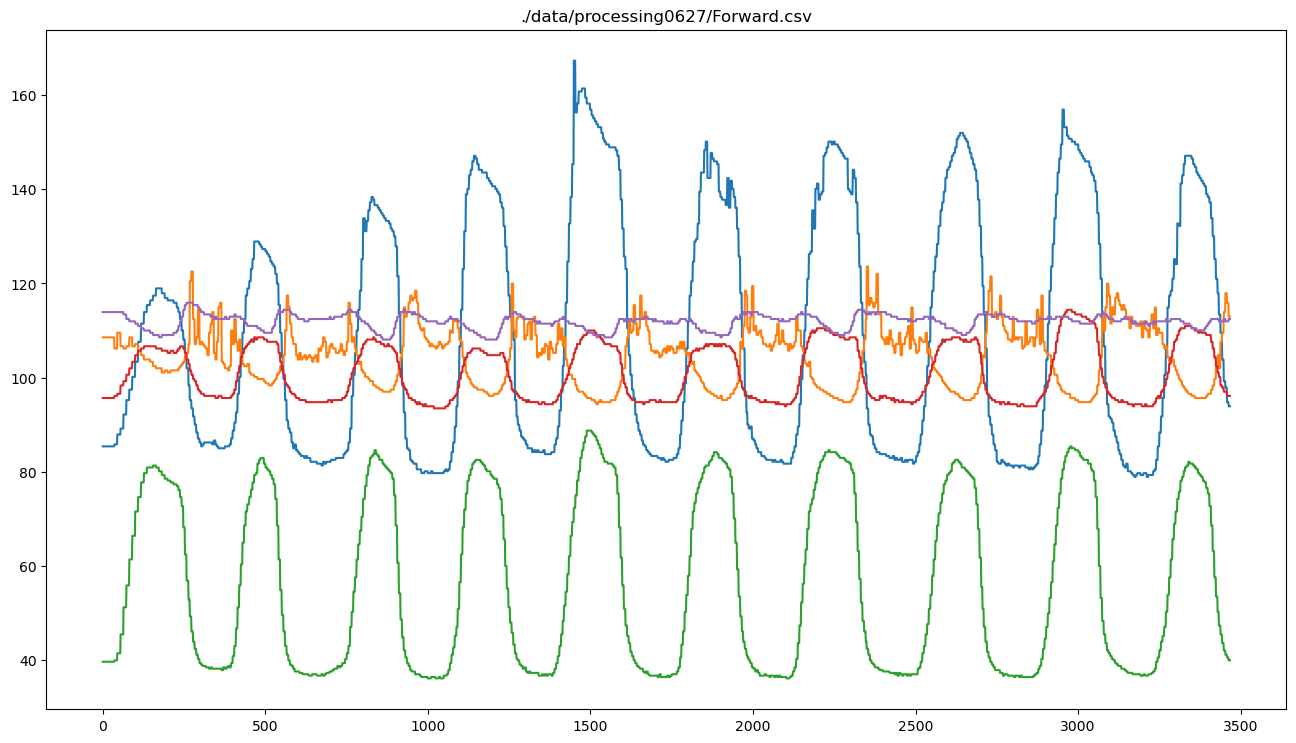

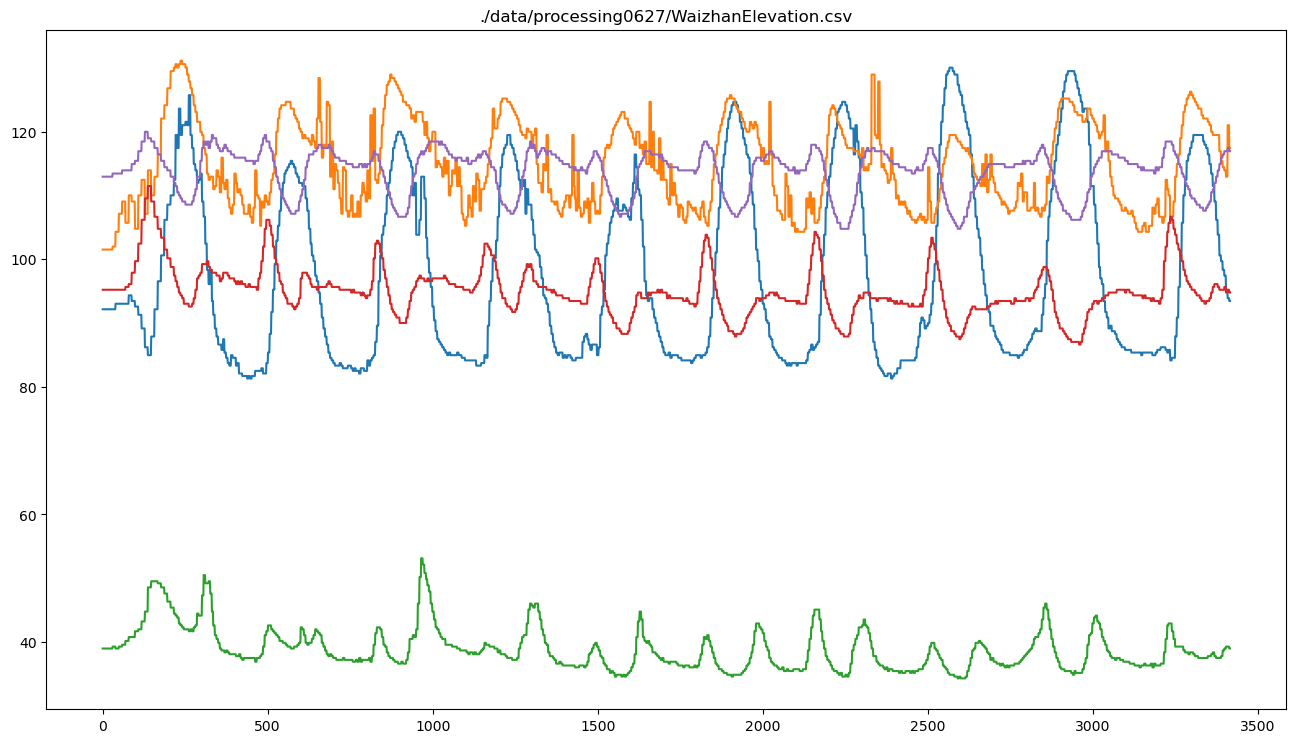

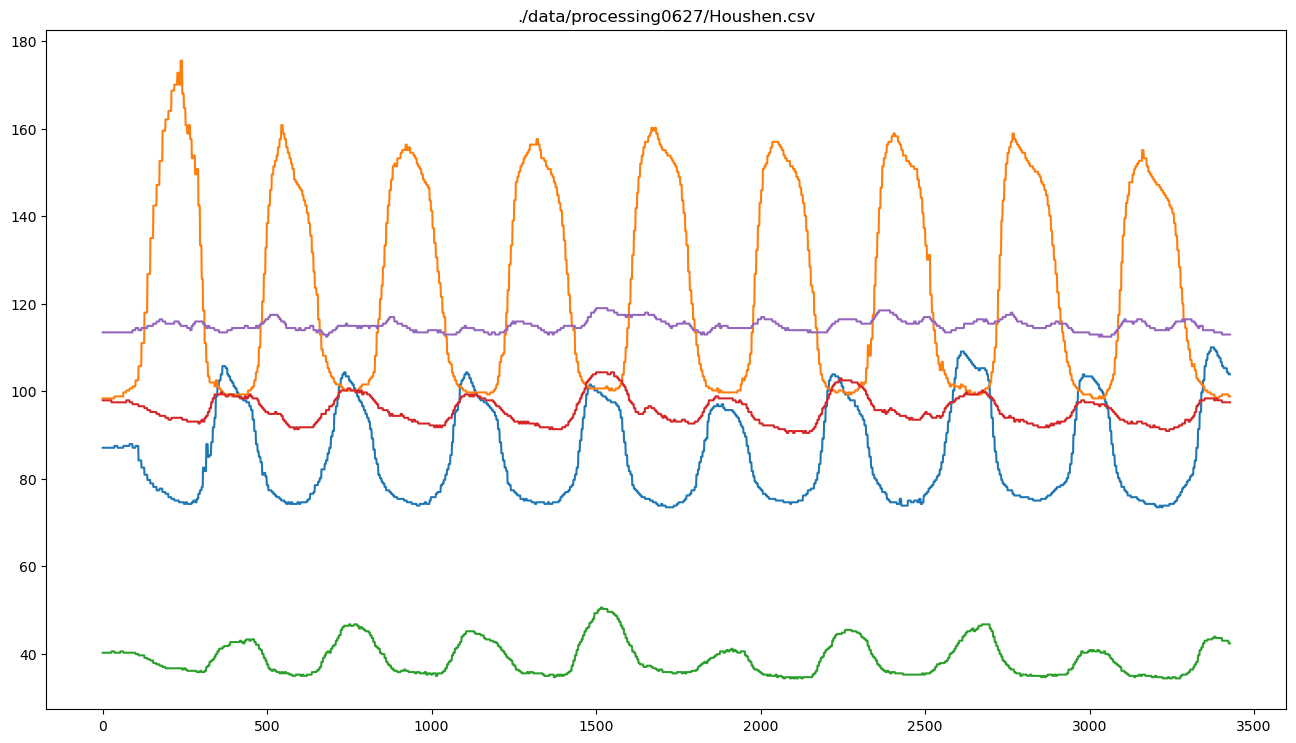

In [33]:
concat_multi_data(folder_path, cut_list)
concat_multi_data(folder_path_0627, cut_list_0627)
with open('data/sensor.npy', 'wb') as f:
    np.save(f, sensor_total)
with open('data/angle.npy', 'wb') as f:
    np.save(f, angle_total)    

In [35]:
with open('data/angle.npy', 'rb') as f:
    print(np.load(f).shape)

(27538, 6)
